In [641]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import missingno as msno
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import sklearn.compose
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import optuna
from sklearn.model_selection import cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import shap
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import RobustScaler
import pickle

In [794]:
# считываем датасет 
df = pd.read_csv('train-a2.csv')

In [796]:
# смотрим размерность
df.shape

(4036207, 45)

In [798]:
# Смотрим соотношение таргета 
df.churn.value_counts(normalize=True)

churn
0    0.706128
1    0.293872
Name: proportion, dtype: float64

Сразу удаляем closet_at

In [800]:
df = df.drop('closed_at', axis = 1)

In [802]:
df.head().T # смотрим вид

,0,1,2,3,4
monthly_income,-0.000735,-0.000742,-0.000742,-0.000742,-0.000742
work_experience,0.952894,0.952894,0.952894,0.952894,0.952894
requested_sum,NaN,NaN,NaN,NaN,NaN
main_agreement_amount,-0.388291,-0.388291,-0.388291,-0.388291,-0.388291
main_agreement_term,-0.340659,-1.145865,-0.685747,0.176974,-1.145865
requested_period_days,-0.389028,-1.294731,-1.11359,-1.385301,-1.657011
requested_amount,-1.05353,-0.436189,-0.259806,1.239449,0.357534
req_app_amount,-0.629296,-0.02014,0.153905,1.633284,0.763061
approved_amount,-0.61762,-0.61762,-0.61762,-0.61762,-0.61762
period_days,-0.340659,-1.145865,-0.685747,0.176974,-1.145865


In [810]:
df.info() # инфо о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 44 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   period_days            float64
 10  days_finish_loan       float64
 11  ag                     float64
 12  cnt_ext                float64
 13  term                   float64
 14  price                  float64
 15  elecs_sum              float64
 16  recurents_sum          float64
 17  tamount                float64
 18  issues                 float64
 19  principal              float64
 20  interest               float64
 21  overdue_interest       float64
 22  overdue_fee       

Смотрим заполняемость таблицы

In [812]:
df.isnull().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

<Axes: >

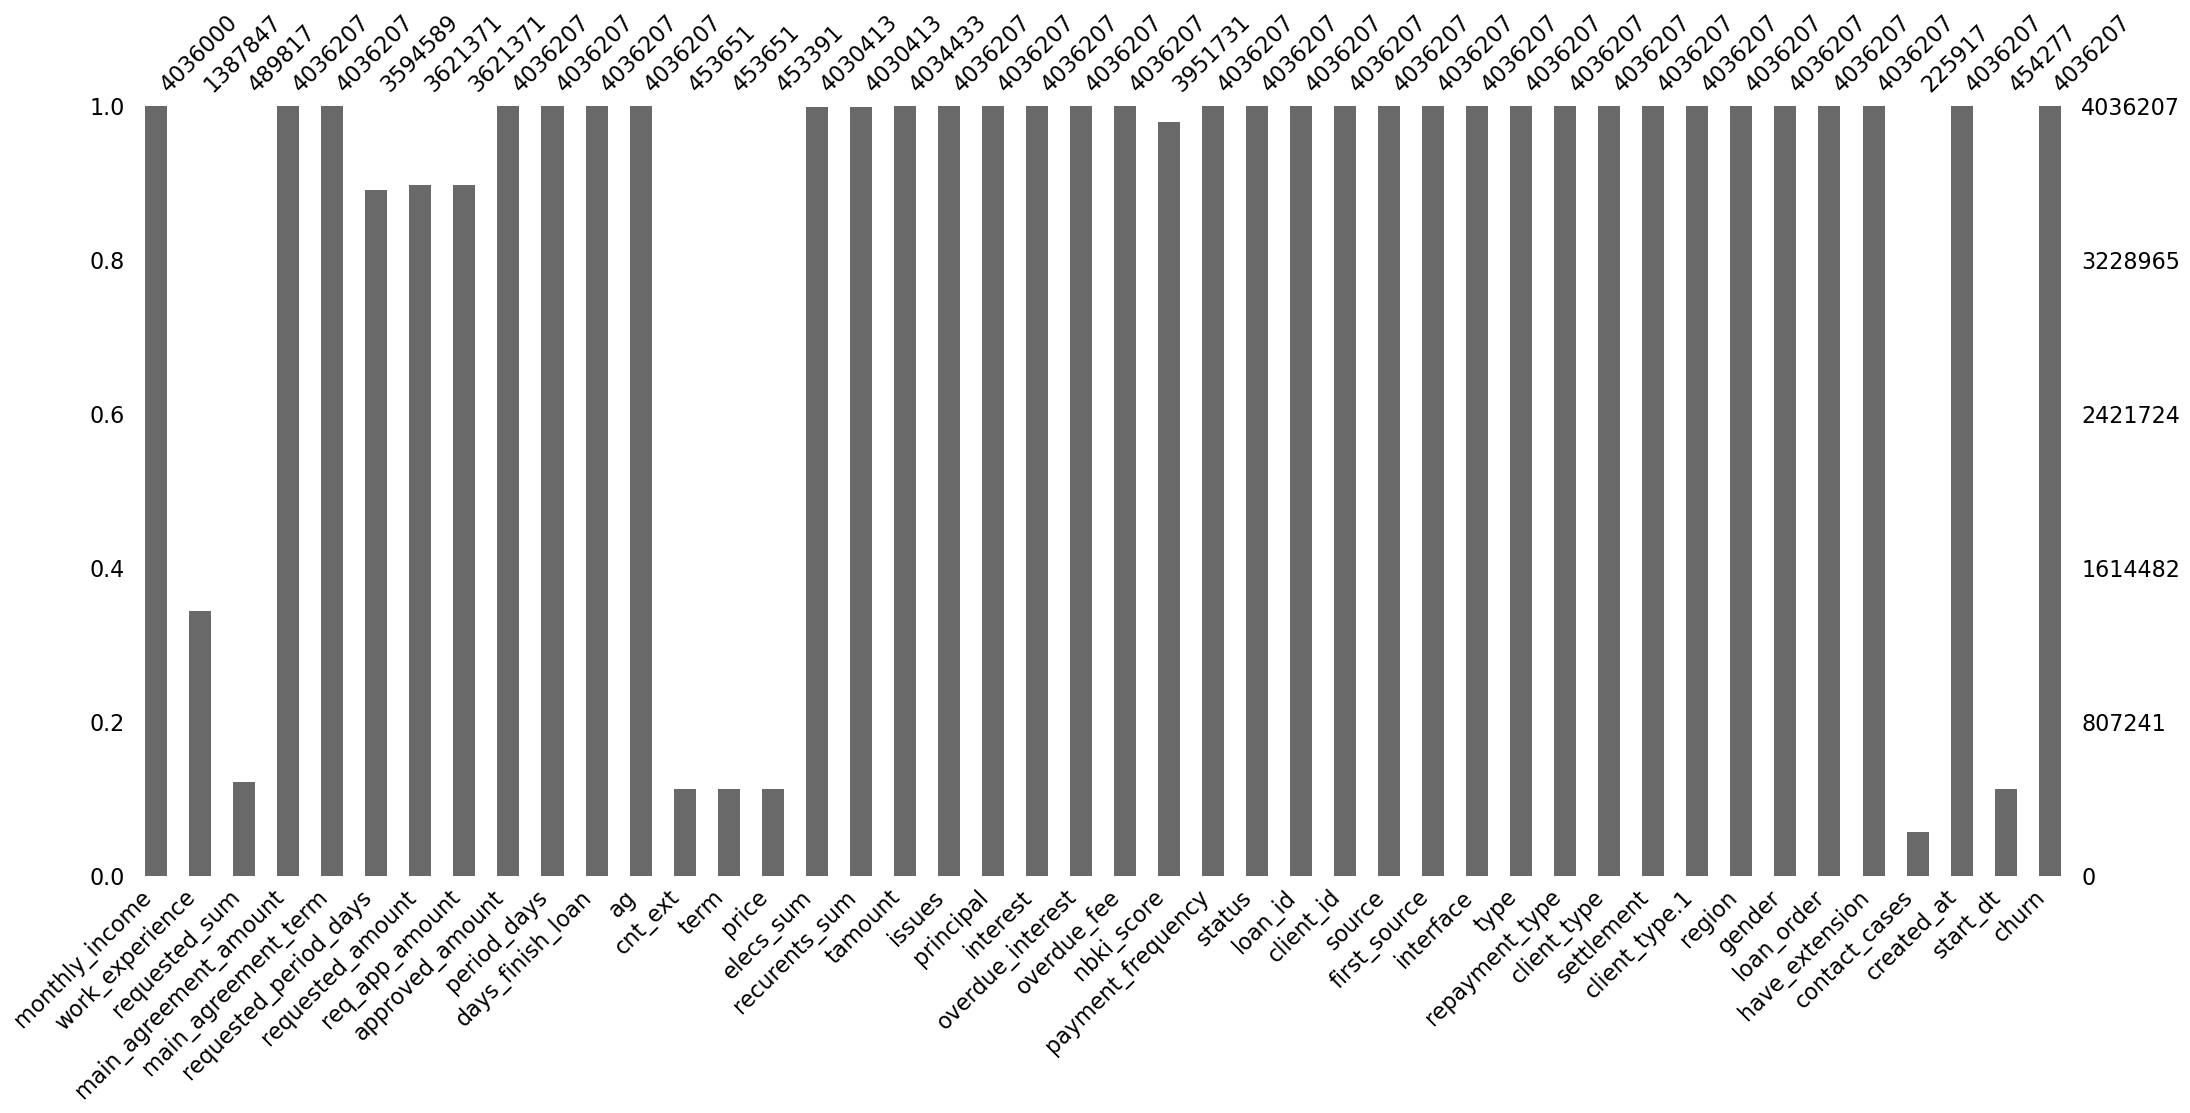

In [814]:
# посмотрим наглядно, как пропуски выглядят визуально 
msno.bar(df)

Что влияет на поведение клиента - его основной доход, срок кредита, штрафы/пени, насколько сам клиент следит за своими кредитами, 
не допуская просрочек или наоборот, он раньше погасил, сколько раз он брал кредит. Из этой логики будем смотреть информацию

In [817]:
df1 = df.copy()

Смотрим на корреляционную матрицу. Отберем для этого числовые признаки

In [820]:
df_numeric = df1.select_dtypes(include='number').columns

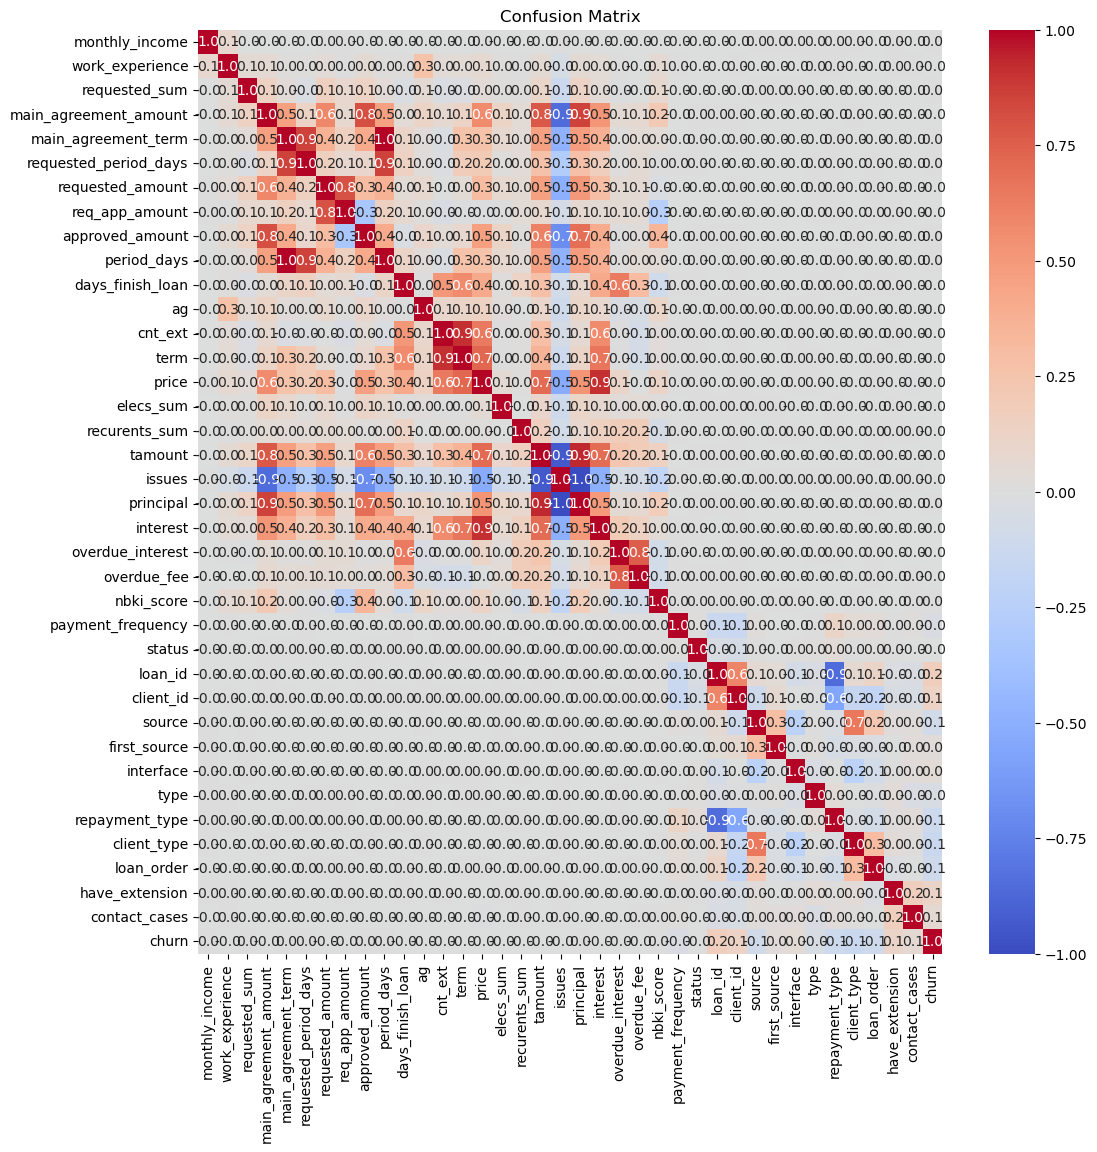

In [822]:
figsize = (12,12)

fig, ax = plt.subplots(figsize=figsize)
plt.title('Confusion Matrix')
hmap = sns.heatmap(df1[df_numeric].corr(), annot = True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

Очень коррелируемый столбец - основной одобренный срок и период страховку, страховку тоже можно удалить

In [825]:
df1 = df1.drop('period_days', axis = 1)

Также сильная корреляция наблюдается с основной одобренной суммой и немного с запрашиваемой суммой, посмотрим на эти показатели детально

In [828]:
df1[['main_agreement_amount', 'approved_amount']]

,main_agreement_amount,approved_amount
0,-0.388291,-0.61762
1,-0.388291,-0.61762
2,-0.388291,-0.61762
3,-0.388291,-0.61762
4,-0.388291,-0.61762
...,...,...
4036202,-0.089509,0.51815
4036203,-0.836463,-0.08314
4036204,0.657444,0.31772
4036205,0.508054,0.18410


<Axes: xlabel='main_agreement_amount', ylabel='approved_amount'>

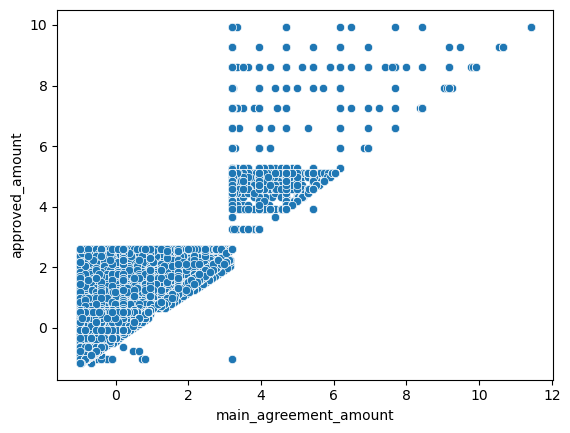

In [830]:
sns.scatterplot(df1, x = 'main_agreement_amount', y = 'approved_amount')

Интересное наблюдение, да, зависимость наблюдается 

<Axes: xlabel='requested_sum', ylabel='approved_amount'>

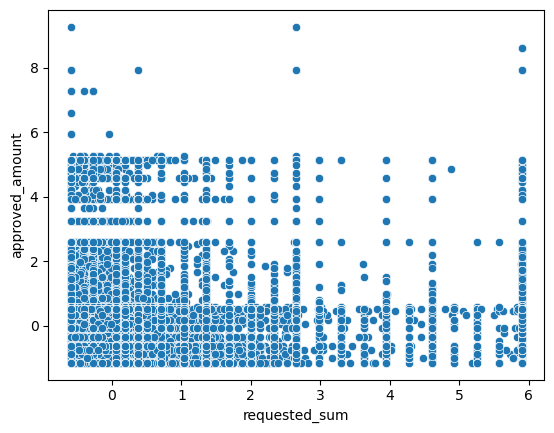

In [833]:
sns.scatterplot(df1, x = 'requested_sum', y = 'approved_amount')

Из табличных данных видно, что основаная одобренная и одобренная сумма хоть и зависимы, но вся таки разные
Сделаю дополнительный столбец разница между одной и второй, основну одобренную удалим, 
разница между запрашиваемой суммой и одобренной у нас есть

In [424]:
def amount(data):
    data['main_app_amount'] = data['approved_amount'] - data['main_agreement_amount']
    data = data.drop('main_agreement_amount', axis = 1)

    return data

In [426]:
amount(df1)

,monthly_income,work_experience,requested_sum,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,ag,...,settlement,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount
0,-0.000735,0.952894,NaN,-0.340659,-0.389028,-1.053530,-0.629296,-0.61762,-0.539615,-0.619312,...,г Москва,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329
1,-0.000742,0.952894,NaN,-1.145865,-1.294731,-0.436189,-0.020140,-0.61762,-0.539615,1.354330,...,г Москва,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329
2,-0.000742,0.952894,NaN,-0.685747,-1.113590,-0.259806,0.153905,-0.61762,-0.502706,1.354330,...,г Пермь,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329
3,-0.000742,0.952894,NaN,0.176974,-1.385301,1.239449,1.633284,-0.61762,-0.465796,1.354330,...,г Самара,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329
4,-0.000742,0.952894,NaN,-1.145865,-1.657011,0.357534,0.763061,-0.61762,-0.133607,1.354330,...,г Москва,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.340659,NaN,NaN,NaN,0.51815,-0.539615,-1.138691,...,г Ногинск,обл Московская,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660
4036203,-0.000747,0.084114,NaN,-0.340659,0.426103,-1.141721,-1.064407,-0.08314,-0.539615,-1.034815,...,г Данилов,обл Ярославская,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323
4036204,-0.000739,NaN,-0.592014,-0.340659,NaN,NaN,NaN,0.31772,-0.539615,-1.450319,...,г Санкт-Петербург,г Санкт-Петербург,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724
4036205,-0.000730,0.084114,NaN,-0.340659,0.426103,-0.083423,-0.194184,0.18410,-0.539615,-0.827063,...,г Нижний Ломов,обл Пензенская,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953


Также есть три столбца с одинаковыми отсутствующими данными, надо выявить причину почему 
Сначала создам df c тремя этими столбцами

In [429]:
df_null = df1[['client_id', 'requested_period_days', 'requested_amount', 'req_app_amount']]

In [431]:
filter_null = df_null[df_null.isna().sum(axis = 1) == 3]
filter_null

,client_id,requested_period_days,requested_amount,req_app_amount
12,1130333,NaN,NaN,NaN
17,250327,NaN,NaN,NaN
21,946447,NaN,NaN,NaN
25,884000,NaN,NaN,NaN
26,951383,NaN,NaN,NaN
...,...,...,...,...
4036200,86771,NaN,NaN,NaN
4036201,118982,NaN,NaN,NaN
4036202,518456,NaN,NaN,NaN
4036204,885599,NaN,NaN,NaN


В принципе, как я и думала везде пустые значения и, так как по запрошенным данным везде пустые значения, то я делаю вывод, что это, возможно, кредитные карты. Посмотрим на тип кредита этих запросов 

In [434]:
ull = df1[['client_id', 'requested_period_days', 'requested_amount', 'req_app_amount', 'type']]
ull 

,client_id,requested_period_days,requested_amount,req_app_amount,type
0,111035,-0.389028,-1.053530,-0.629296,2
1,604426,-1.294731,-0.436189,-0.020140,1
2,334703,-1.113590,-0.259806,0.153905,2
3,362893,-1.385301,1.239449,1.633284,2
4,537669,-1.657011,0.357534,0.763061,1
...,...,...,...,...,...
4036202,518456,NaN,NaN,NaN,2
4036203,723610,0.426103,-1.141721,-1.064407,2
4036204,885599,NaN,NaN,NaN,2
4036205,439105,0.426103,-0.083423,-0.194184,2


In [436]:
ull.type.unique()

array([2, 1, 3, 0])

In [438]:
df1.type.unique() #к сожалению, догадки не верные, но посмотрим на еще один столбец - запрашиваемая сумма, если клиент alfa

array([2, 1, 3, 0])

In [440]:
df_null2 = df1[['client_id', 'requested_period_days', 'requested_amount', 'req_app_amount', 'requested_sum']]
df_null2

,client_id,requested_period_days,requested_amount,req_app_amount,requested_sum
0,111035,-0.389028,-1.053530,-0.629296,NaN
1,604426,-1.294731,-0.436189,-0.020140,NaN
2,334703,-1.113590,-0.259806,0.153905,NaN
3,362893,-1.385301,1.239449,1.633284,NaN
4,537669,-1.657011,0.357534,0.763061,NaN
...,...,...,...,...,...
4036202,518456,NaN,NaN,NaN,-0.592014
4036203,723610,0.426103,-1.141721,-1.064407,NaN
4036204,885599,NaN,NaN,NaN,-0.592014
4036205,439105,0.426103,-0.083423,-0.194184,NaN


Делаем вывод, что частично мы можем заполнить недостающие пропуски суммой из последнего столбца.
Соот-но, потом заполним ии резницу междy запрошенной и одобренной

In [443]:
def columns_req_amount(data):
    data['requested_amount'] = data['requested_amount'].fillna(data['requested_sum'])
    data['req_app_amount'] = data['approved_amount'] - data['requested_amount']
    
    return data

In [445]:
columns_req_amount(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,settlement,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,г Москва,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,г Москва,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,г Пермь,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,г Самара,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,г Москва,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,NaN,-0.592014,1.110164,0.51815,-0.539615,...,г Ногинск,обл Московская,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,г Данилов,обл Ярославская,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,NaN,-0.592014,0.909734,0.31772,-0.539615,...,г Санкт-Петербург,г Санкт-Петербург,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,г Нижний Ломов,обл Пензенская,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953


In [446]:
df1.requested_amount.isnull().sum()

102077

In [449]:
df1.req_app_amount.isnull().sum()

102077

Все равно остались пропуски - обозначим их меньше, чем минимальное значение, чтобы при масштабировании значений эти признаки приняли значения 0, также поступим с запрашенным периодом.

In [453]:
def full_colums_req(data):
    data['requested_period_days'] = data['requested_period_days'].fillna(data['requested_period_days'].min() - 0.05)
    data['requested_amount'] = data['requested_amount'].fillna(data['requested_amount'].min() - 0.05)
    data['req_app_amount'] = data['req_app_amount'].fillna(data['req_app_amount'].min() - 0.05)

    return data

In [455]:
full_colums_req(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,settlement,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,г Москва,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,г Москва,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,г Пермь,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,г Самара,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,г Москва,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-1.707011,-0.592014,1.110164,0.51815,-0.539615,...,г Ногинск,обл Московская,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,г Данилов,обл Ярославская,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-1.707011,-0.592014,0.909734,0.31772,-0.539615,...,г Санкт-Петербург,г Санкт-Петербург,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,г Нижний Ломов,обл Пензенская,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953


In [457]:
df1.req_app_amount.isnull().sum()

0

In [459]:
df1.requested_amount.isnull().sum()

0

Также сделаем дополнительный столбец - разницу между запрошеннным сроком и сроком одобренным, удалим сразу запрашиваемый срок

In [462]:
def main_req_term(data):
    data['main_req_term'] = data['main_agreement_term'] - data['requested_period_days']

    return data

In [464]:
main_req_term(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_amount,req_app_amount,approved_amount,days_finish_loan,ag,...,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-1.053530,0.435910,-0.61762,-0.539615,-0.619312,...,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329,0.048370
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-0.436189,-0.181431,-0.61762,-0.539615,1.354330,...,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329,0.148865
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-0.259806,-0.357814,-0.61762,-0.502706,1.354330,...,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329,0.427843
3,-0.000742,0.952894,NaN,-0.388291,0.176974,1.239449,-1.857069,-0.61762,-0.465796,1.354330,...,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329,1.562275
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,0.357534,-0.975154,-0.61762,-0.133607,1.354330,...,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329,0.511146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-0.592014,1.110164,0.51815,-0.539615,-1.138691,...,обл Московская,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660,1.366353
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,-1.141721,1.058581,-0.08314,-0.539615,-1.034815,...,обл Ярославская,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323,-0.766762
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-0.592014,0.909734,0.31772,-0.539615,-1.450319,...,г Санкт-Петербург,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724,1.366353
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,-0.083423,0.267524,0.18410,-0.539615,-0.827063,...,обл Пензенская,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953,-0.766762


<Axes: xlabel='main_agreement_term', ylabel='requested_period_days'>

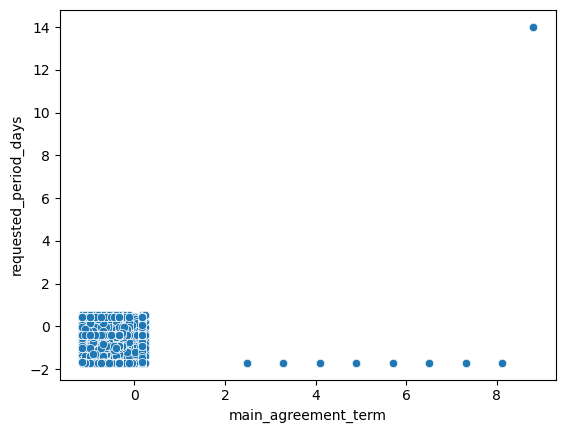

In [468]:
sns.scatterplot(df1, x = 'main_agreement_term', y = 'requested_period_days')

Посмотрим на клиентов, кто взял пролонгацию на кредит

In [471]:
have_extension = df1.loc[df1['have_extension'] > 0] 
have_extension.churn.value_counts()

churn
0    256662
1    197615
Name: count, dtype: int64

In [473]:
positive = (have_extension[have_extension.churn == 0].shape[0])/ len(have_extension)*100
negative = (have_extension[have_extension.churn == 1].shape[0])/ len(have_extension)*100
print(f'{round(positive, 2)}%, {round(negative, 2)}%')

56.5%, 43.5%


Посмортим на остальные столбцы с пролонгацией

In [476]:
df1['cnt_ext'].unique()

array([        nan,  1.40775186, -0.72060812, -0.01115479,  2.11720518,
        0.69829853,  2.8266585 ,  3.53611183])

In [478]:
df1['term'].unique()

array([            nan, -6.12323585e-01, -5.61187307e-01, -7.91300557e-01,
       -5.35619168e-01,  2.05856860e-01,  8.19492194e-01,  1.73994519e+00,
        2.50698936e+00, -8.16868696e-01,  2.56993138e-01, -2.54369640e-01,
        9.72901027e-01, -1.02141381e+00, -9.95845669e-01, -6.63459863e-01,
        7.17219638e-01,  2.82561277e-01,  4.61538249e-01,  1.02403730e+00,
       -9.44709391e-01,  2.63483006e+00,  1.35642311e+00,  1.22858242e+00,
       -1.07255009e+00, -3.05505918e-01,  1.04960544e+00, -4.07778474e-01,
       -7.14596141e-01, -9.70277530e-01,  1.84221775e+00,  5.24480265e-02,
       -6.89028002e-01, -7.65732419e-01, -8.93573113e-01, -4.33346613e-01,
       -4.98245291e-02,  1.61210450e+00, -9.19141252e-01,  5.89378944e-01,
        1.12630986e+00, -1.04698195e+00, -1.14925450e+00,  1.03584304e-01,
        5.12674527e-01,  9.21764749e-01,  7.80161654e-02, -1.00960807e-01,
       -1.12368636e+00, -8.42436835e-01, -7.40164280e-01, -2.03233363e-01,
       -5.10051029e-01, -

In [480]:
df1['price'].value_counts()

price
-0.738997    4983
-0.145848    4545
-0.400055    4475
-0.654262    4429
-0.552579    4344
             ... 
 2.315213       1
-0.257345       1
 1.158004       1
 5.907452       1
-0.704811       1
Name: count, Length: 43324, dtype: int64

Эти столбцы определенно играют роль, так как с пролонгацией около 50% отток, соот-но, заполним остальные пропуски
по схеме минимального значения, чтобы при масштабировании они приняли 0, а их мы заполняем 0, так как остальные, как мы знаем, пролонгацию не брали

In [483]:
def full_colums_dt(data):
    data['cnt_ext'] = data['cnt_ext'].fillna(data['cnt_ext'].min() - 0.05)
    data['term'] = data['term'].fillna(data['term'].min() - 0.05)
    data['price'] = data['price'].fillna(data['price'].min() - 0.05)

    return data

In [485]:
full_colums_dt(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329,0.048370
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329,0.148865
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329,0.427843
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329,1.562275
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329,0.511146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-1.707011,-0.592014,1.110164,0.51815,-0.539615,...,обл Московская,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660,1.366353
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,обл Ярославская,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323,-0.766762
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-1.707011,-0.592014,0.909734,0.31772,-0.539615,...,г Санкт-Петербург,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724,1.366353
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,обл Пензенская,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953,-0.766762


Также создадим столбец разницу между одобренным сроком кредита и время, завтраченное на кредит

In [488]:
def closed_time(data):
    data['closed_loan'] = data['main_agreement_term'] - data['requested_period_days']

    return data

In [490]:
closed_time(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term,closed_loan
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,male,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329,0.048370,0.048370
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,female,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329,0.148865,0.148865
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,male,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329,0.427843,0.427843
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329,1.562275,1.562275
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,female,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329,0.511146,0.511146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-1.707011,-0.592014,1.110164,0.51815,-0.539615,...,female,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660,1.366353,1.366353
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,female,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323,-0.766762,-0.766762
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-1.707011,-0.592014,0.909734,0.31772,-0.539615,...,male,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724,1.366353,1.366353
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,male,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953,-0.766762,-0.766762


Помотрим на столбцы tamount и principal - у них очень большая корреляция

<Axes: xlabel='principal', ylabel='tamount'>

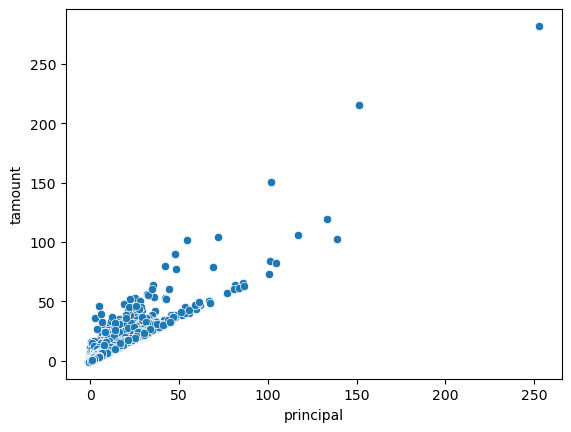

In [493]:
sns.scatterplot(df1, x = 'principal', y = 'tamount')

In [495]:
df1[['principal', 'tamount', 'issues']] #очень прослеживается корреляция, сделаем из них признак и один столбец удалим

,principal,tamount,issues
0,-0.347703,-0.434972,0.347703
1,-0.347703,-0.434972,0.347703
2,-0.347703,-0.429509,0.347703
3,-0.347703,-0.413118,0.347703
4,-0.347703,-0.320236,0.347703
...,...,...,...
4036202,-0.095187,-0.252851,0.095187
4036203,-0.726477,-0.708154,0.726477
4036204,0.536102,0.202452,-0.536102
4036205,0.409844,0.111392,-0.409844


In [497]:
def tam_prin_income(data):
    data['princ_tamount']= data['principal']-data['tamount']
    data.drop('tamount', axis = 1)

    return data

In [499]:
tam_prin_income(df1)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term,closed_loan,princ_tamount
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329,0.048370,0.048370,0.087269
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329,0.148865,0.148865,0.087269
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329,0.427843,0.427843,0.081806
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329,1.562275,1.562275,0.065415
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329,0.511146,0.511146,-0.027467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-1.707011,-0.592014,1.110164,0.51815,-0.539615,...,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660,1.366353,1.366353,0.157664
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323,-0.766762,-0.766762,-0.018323
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-1.707011,-0.592014,0.909734,0.31772,-0.539615,...,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724,1.366353,1.366353,0.333650
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953,-0.766762,-0.766762,0.298453


<Axes: xlabel='issues', ylabel='elecs_sum'>

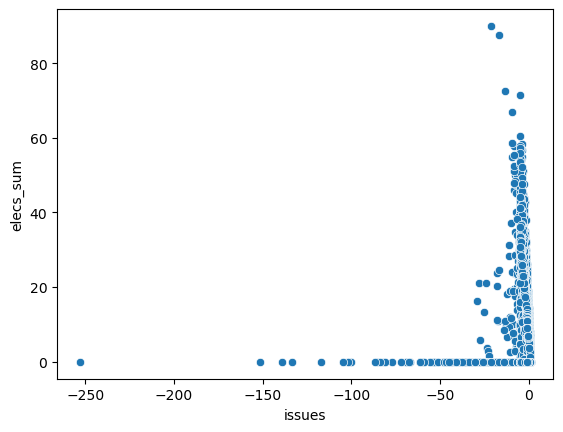

In [315]:
sns.scatterplot(df1, x = 'issues', y = 'elecs_sum')

In [317]:
df1[['issues', 'elecs_sum', 'recurents_sum']]

,issues,elecs_sum,recurents_sum
0,0.347703,-0.063933,-0.143015
1,0.347703,-0.063933,-0.143015
2,0.347703,-0.063933,-0.143015
3,0.347703,-0.063933,-0.143015
4,0.347703,-0.063933,-0.143015
...,...,...,...
4036202,0.095187,-0.063933,-0.143015
4036203,0.726477,-0.063933,-0.143015
4036204,-0.536102,-0.063933,-0.143015
4036205,-0.409844,-0.063933,-0.143015


In [325]:
df1[['principal', 'tamount', 'issues', 'recurents_sum']] 

,principal,tamount,issues,recurents_sum
0,-0.347703,-0.434972,0.347703,-0.143015
1,-0.347703,-0.434972,0.347703,-0.143015
2,-0.347703,-0.429509,0.347703,-0.143015
3,-0.347703,-0.413118,0.347703,-0.143015
4,-0.347703,-0.320236,0.347703,-0.143015
...,...,...,...,...
4036202,-0.095187,-0.252851,0.095187,-0.143015
4036203,-0.726477,-0.708154,0.726477,-0.143015
4036204,0.536102,0.202452,-0.536102,-0.143015
4036205,0.409844,0.111392,-0.409844,-0.143015


In [339]:
df1.recurents_sum.value_counts() 

recurents_sum
-0.143015     3723584
-0.125350       33154
-0.072356       22533
-0.107686       18147
-0.090021       13730
               ...   
 4.749245           1
 3.104928           1
 0.087504           1
 4.190364           1
 10.877009          1
Name: count, Length: 22777, dtype: int64

<Axes: xlabel='issues', ylabel='recurents_sum'>

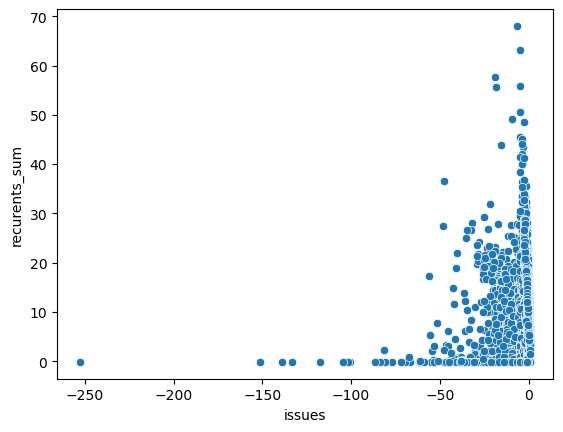

In [319]:
sns.scatterplot(df1, x = 'issues', y = 'recurents_sum')

<Axes: xlabel='elecs_sum', ylabel='recurents_sum'>

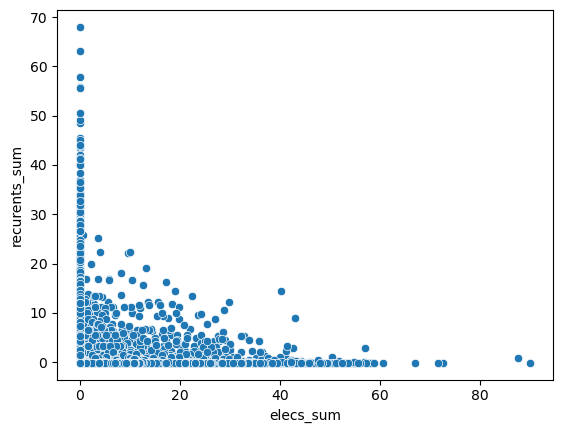

In [501]:
sns.scatterplot(df1, x = 'elecs_sum', y = 'recurents_sum')

<Axes: xlabel='principal', ylabel='recurents_sum'>

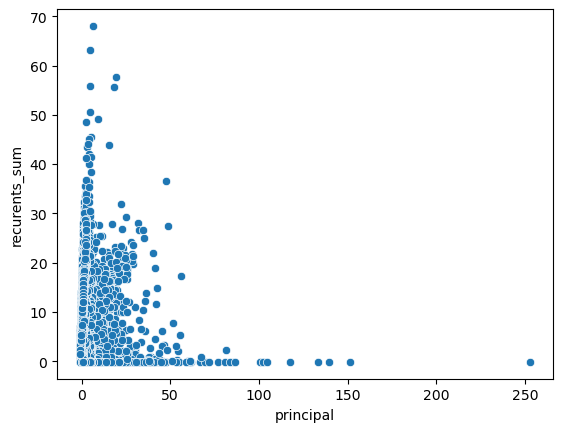

In [502]:
sns.scatterplot(df1, x = 'principal', y = 'recurents_sum')

In [503]:
df1.isnull().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days          0
requested_amount               0
req_app_amount                 0
approved_amount                0
days_finish_loan               0
ag                             0
cnt_ext                        0
term                           0
price                          0
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface                      0
type                           0
repayment_type                 0
client_typ

In [347]:
df1.nbki_score.describe().apply(lambda x: f'{x:.6f}')

count     3951731.000000
mean            0.000327
std             1.000063
min            -1.766011
25%            -0.811981
50%            -0.178851
75%             0.744824
max             2.535799
Name: nbki_score, dtype: object

In [507]:
df1.loc[df1.nbki_score.isnull()]

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term,closed_loan,princ_tamount
12,-0.000739,NaN,0.706333,0.059882,-0.340659,-1.707011,0.706333,-0.923093,-0.21676,-0.152062,...,5,0,NaN,2024-07-19 15:07:34,NaN,1,-0.276641,1.366353,1.366353,0.192861
25,-0.000747,NaN,-0.332345,-0.537681,-0.340659,-1.707011,-0.332345,-0.418895,-0.75124,-0.521161,...,3,0,NaN,2023-12-03 17:28:22,NaN,0,-0.213559,1.366353,1.366353,0.052072
69,-0.000743,NaN,NaN,-0.388291,0.176974,0.426103,-0.524381,-0.093239,-0.61762,-0.539615,...,2,0,NaN,2023-04-25 11:33:50,NaN,0,-0.229329,-0.249129,-0.249129,0.083627
70,-0.000743,NaN,NaN,-0.388291,0.176974,-0.389028,-0.744860,0.127240,-0.61762,-0.355066,...,15,0,NaN,2024-08-30 20:02:25,NaN,0,-0.229329,0.566003,0.566003,0.049164
71,-0.000743,NaN,NaN,-0.388291,0.176974,0.426103,1.239449,-1.857069,-0.61762,-0.428886,...,5,0,NaN,2023-07-03 07:33:11,NaN,0,-0.229329,-0.249129,-0.249129,0.054487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036177,-0.000743,NaN,-0.332345,-0.537681,-0.340659,-0.389028,1.239449,-1.990689,-0.75124,-0.539615,...,1,0,NaN,2023-10-28 18:09:21,NaN,1,-0.213559,0.048370,0.048370,0.052072
4036178,-0.000743,NaN,NaN,-0.537681,0.176974,0.426103,1.239449,-1.990689,-0.75124,-0.539615,...,2,1,NaN,2024-01-15 17:45:29,2024-02-14 10:17:13,1,-0.213559,-0.249129,-0.249129,0.048429
4036180,-0.000753,NaN,-0.592014,0.508054,-0.340659,-0.389028,1.239449,-1.055349,0.18410,-0.539615,...,3,0,NaN,2022-10-18 08:31:27,NaN,0,-0.323953,0.048370,0.048370,0.298453
4036189,-0.000750,NaN,-0.468671,-0.537681,-0.340659,-0.389028,0.269343,-1.020583,-0.75124,-0.539615,...,8,0,NaN,2024-07-26 04:16:40,NaN,0,-0.213559,0.048370,0.048370,0.052072


In [511]:
df1.work_experience.value_counts()

work_experience
 0.952894    556512
 0.084114    380849
-0.784665    272201
-1.653445    116386
-2.522225     61899
Name: count, dtype: int64

<Axes: xlabel='ag', ylabel='work_experience'>

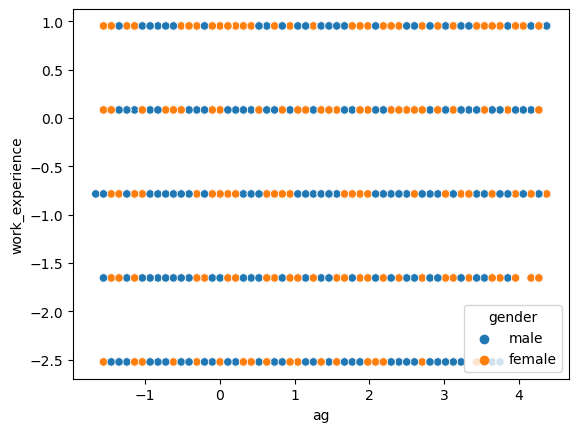

In [513]:
sns.scatterplot(df1, x = 'ag', y = 'work_experience', hue = 'gender')

In [246]:
df1.work_experience.value_counts()

work_experience
3.475119    556512
2.606339    380849
1.737560    272201
0.868780    116386
0.000000     61899
Name: count, dtype: int64

In [768]:
df2 = df1.copy()

Преобразуем столбец с регионом

In [771]:
def clean_region(data, column_name):
    data[column_name] = data[column_name].str.lower()
    words_to_remove = r'\b(г|аобл|обл(асть)?|край|респ(ублика)?|автономный|округ|ао|народная|эл)\b'
    words_remove2 = r'(\s\-\s(югра|кузбасс|алания|чувашия))|\s.якутия.'
    data[column_name] = data[column_name].str.replace(words_to_remove,'', regex=True, case=False)
    data[column_name] = data[column_name].str.replace(words_remove2,'', regex=True, case=False)
    respublic = r'(((\-)?)(балкарская|черкесская|ненецкий|мансийский))|северная|санкт\-'
    data[column_name] = data[column_name].str.replace(respublic,'', regex=True, case=False)
    data[column_name] = data[column_name].str.replace(r'\s+',' ', regex=True).str.strip()        

    return data

In [773]:
clean_region(df2, 'region')

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,days_finish_loan,...,loan_order,have_extension,contact_cases,created_at,start_dt,churn,main_app_amount,main_req_term,closed_loan,princ_tamount
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,0.435910,-0.61762,-0.539615,...,2,0,NaN,2022-12-23 17:50:25,NaN,0,-0.229329,0.048370,0.048370,0.087269
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.181431,-0.61762,-0.539615,...,14,0,NaN,2024-06-29 22:26:08,NaN,0,-0.229329,0.148865,0.148865,0.087269
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,-0.357814,-0.61762,-0.502706,...,10,0,NaN,2023-04-10 21:06:38,NaN,0,-0.229329,0.427843,0.427843,0.081806
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,-1.857069,-0.61762,-0.465796,...,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0,-0.229329,1.562275,1.562275,0.065415
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,-0.975154,-0.61762,-0.133607,...,17,0,NaN,2024-07-15 10:40:35,NaN,0,-0.229329,0.511146,0.511146,-0.027467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036202,-0.000747,NaN,-0.592014,-0.089509,-0.340659,-1.707011,-0.592014,1.110164,0.51815,-0.539615,...,2,0,NaN,2023-05-03 13:08:33,NaN,0,0.607660,1.366353,1.366353,0.157664
4036203,-0.000747,0.084114,NaN,-0.836463,-0.340659,0.426103,-1.141721,1.058581,-0.08314,-0.539615,...,3,0,NaN,2023-09-13 17:52:03,NaN,0,0.753323,-0.766762,-0.766762,-0.018323
4036204,-0.000739,NaN,-0.592014,0.657444,-0.340659,-1.707011,-0.592014,0.909734,0.31772,-0.539615,...,6,0,NaN,2023-12-13 20:56:45,NaN,0,-0.339724,1.366353,1.366353,0.333650
4036205,-0.000730,0.084114,NaN,0.508054,-0.340659,0.426103,-0.083423,0.267524,0.18410,-0.539615,...,3,0,NaN,2024-08-27 23:36:06,NaN,0,-0.323953,-0.766762,-0.766762,0.298453


In [775]:
def remove_duplicate_words(text):
    # Используем регулярное выражение для замены повторяющихся слов на одно слово
    return re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text)

df2.region = df2.region.apply(remove_duplicate_words)

In [776]:
df2.region.unique()

array(['москва', 'пермский', 'самарская', 'удмуртская', 'калининградская',
       'ленинградская', 'челябинская', 'московская', 'ставропольский',
       'ханты', 'башкортостан', 'ульяновская', 'красноярский',
       'петербург', 'татарстан', 'новосибирская', 'ивановская', 'омская',
       'бурятия', 'брянская', 'тульская', 'владимирская', 'псковская',
       'волгоградская', 'тверская', 'кемеровская', 'иркутская',
       'камчатский', 'краснодарский', 'ростовская', 'хакасия',
       'чукотский', 'свердловская', 'калмыкия', 'саратовская',
       'забайкальский', 'кировская', 'алтайский', 'карелия',
       'магаданская', 'архангельская', 'ямало', 'хабаровский', 'дагестан',
       'нижегородская', 'мурманская', 'пензенская', 'приморский',
       'рязанская', 'воронежская', 'коми', 'чувашия чувашская',
       'липецкая', 'белгородская', 'томская', 'тюменская', 'курская',
       'тыва', 'сахалинская', 'смоленская', 'костромская', 'ярославская',
       'новгородская', 'орловская', 'осетия', 

In [788]:
df2.isnull().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days          0
requested_amount               0
req_app_amount                 0
approved_amount                0
days_finish_loan               0
ag                             0
cnt_ext                        0
term                           0
price                          0
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface                      0
type                           0
repayment_type                 0
client_typ

In [781]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 44 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   monthly_income         float64
 1   work_experience        float64
 2   requested_sum          float64
 3   main_agreement_amount  float64
 4   main_agreement_term    float64
 5   requested_period_days  float64
 6   requested_amount       float64
 7   req_app_amount         float64
 8   approved_amount        float64
 9   days_finish_loan       float64
 10  ag                     float64
 11  cnt_ext                float64
 12  term                   float64
 13  price                  float64
 14  elecs_sum              float64
 15  recurents_sum          float64
 16  tamount                float64
 17  issues                 float64
 18  principal              float64
 19  overdue_fee            float64
 20  nbki_score             float64
 21  payment_frequency      int64  
 22  status            

In [783]:
def fit():
    X = df2.drop('churn', axis = 1)
    y = df2['churn']
    
    numerical_features = sklearn.compose.make_column_selector(dtype_include=['int64', 'float64'])
    categorical_features = sklearn.compose.make_column_selector(dtype_include=['object'])
    
    numerical_transform = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy = 'median')),
        ('rscaler', RobustScaler())
    ])
        
    categorical_transform = Pipeline(steps=[
        ('encoder', OrdinalEncoder())
    ])
    
    column_transforms = ColumnTransformer(transformers = [
        ('numerical', numerical_transform, numerical_features),
        ('categorical', categorical_transform, categorical_features),
    ])

    preprocessor = Pipeline(steps=[
        ('column_transforms', column_transforms),
    ])
    
    models = [XGBClassifier(),
             HistGradientBoostingClassifier()]

    best_score = .0
    best_pipe = None
    for model in models:
        pipe = Pipeline(steps = [
            ('prepocessor', preprocessor),
            ('models', model)
        ])
        
        score = cross_val_score(pipe, X, y, cv = 4, scoring = 'f1')
        print(f'model: {type(model).__name__}, f1: {score.mean():.4f}')

        if score.mean() > best_score:
            best_score =score.mean()
            best_pipe = pipe
            
            best_pipe.fit(X, y)
        with open('alfa-2.pkl', 'wb') as file:
            pickle.dump(best_pipe, file)

In [ ]:
fit()

model: XGBClassifier, f1: nan


In [600]:
feature_names = preprocessor.named_steps['column_transforms'].get_feature_names_out()
X = pd.DataFrame(X, columns=feature_names)

In [601]:
fit_xg = model.fit(X, y)

In [602]:
explainer = shap.TreeExplainer(fit_xg)
shap_values = explainer(X)

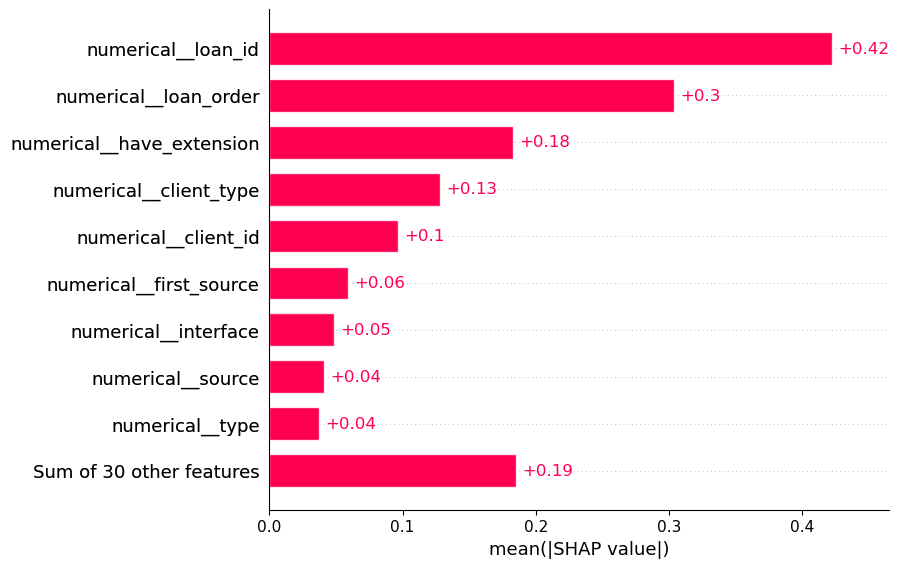

In [603]:
shap.plots.bar(shap_values)

In [116]:
df4

,repayment_type,loan_order,have_extension,interface,first_source,client_type,source,type,gender
0,3,2,0,0,0,1,11,2,male
1,0,14,0,2,0,1,11,1,female
2,3,10,0,2,4,1,11,2,male
3,1,2,1,2,0,1,11,2,female
4,2,17,0,2,11,1,11,1,female
...,...,...,...,...,...,...,...,...,...
4036202,3,2,0,0,6,1,11,2,female
4036203,2,3,0,2,11,1,7,2,female
4036204,1,6,0,2,10,1,11,2,male
4036205,0,3,0,2,11,1,11,2,male


In [737]:
with open('alfa-2.pkl', 'rb') as file:
    model_a = pickle.load(file)

In [739]:
df_test = pd.read_csv('test (1).csv')

In [740]:
df_test.head()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,...,client_type,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt
0,-0.000742,0.952894,NaN,-0.089509,0.176974,-1.385301,0.181151,0.414972,-0.350380,0.176974,...,1,г Москва,repeated,г Москва,male,15,0,NaN,2024-04-29 18:20:22,NaN
1,-0.000742,0.952894,NaN,4.242822,8.114011,NaN,1.239449,-1.760586,4.593562,8.114011,...,1,г Коркино,repeated,обл Челябинская,female,5,0,NaN,2023-01-17 04:59:57,NaN
2,-0.000749,-1.653445,NaN,-0.687072,0.176974,-1.385301,-1.053530,-0.455251,-0.884860,0.176974,...,0,г Екатеринбург,new,обл Свердловская,male,1,0,NaN,2023-08-29 14:04:47,NaN
3,-0.000749,-1.653445,NaN,-0.687072,0.176974,0.426103,1.239449,1.807328,-0.884860,0.176974,...,1,г Черемхово,repeated,обл Иркутская,female,3,0,NaN,2023-12-14 15:47:39,NaN
4,-0.000745,NaN,NaN,0.806835,-0.340659,-0.389028,-0.083423,-0.368229,0.451340,-0.340659,...,1,г Лысьва поселок Кормовище,repeated,Пермский край Пермский,male,4,0,NaN,2024-03-13 05:47:49,NaN


In [741]:
predict = model_a.predict(df_test)

ValueError: columns are missing: {'main_req_term', 'closed_loan', 'main_app_amount', 'princ_tamount'}

In [298]:
df_predict = pd.DataFrame({'class': predict})

In [300]:
df_predict

,class
0,0
1,0
2,0
3,0
4,0
...,...
1348738,0
1348739,0
1348740,0
1348741,0


In [302]:
id_predict = pd.concat([df_test['loan_id'], df_predict], axis = 1)

In [304]:
id_predict 

,loan_id,class
0,4057275,0
1,548313,0
2,1978430,0
3,2884196,0
4,3647374,0
...,...,...
1348738,2763237,0
1348739,443575,0
1348740,3443538,0
1348741,1647042,0


In [306]:
id_predict.to_csv('answer2_bank.csv', encoding='utf-8', index = False)